# CIS4930 : Student Depression Prediction
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, r2_score
from imblearn.over_sampling import SMOTE

## Data Exploration

In [2]:
depression_df = pd.read_csv('student_depression_prediction.csv')
display(depression_df.head())
display(depression_df.tail())

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
27896,140685,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,5-6 hours,Unhealthy,Class 12,Yes,7.0,1.0,Yes,0
27897,140686,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,Less than 5 hours,Healthy,MSc,No,0.0,3.0,Yes,0
27898,140689,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,5-6 hours,Unhealthy,MD,No,12.0,2.0,No,0
27899,140690,Female,18.0,Ludhiana,Student,5.0,0.0,6.88,2.0,0.0,Less than 5 hours,Healthy,Class 12,Yes,10.0,5.0,No,1
27900,140699,Male,27.0,Patna,Student,4.0,0.0,9.24,1.0,0.0,Less than 5 hours,Healthy,BCA,Yes,2.0,3.0,Yes,1


In [ ]:
display(depression_df.info())
display(depression_df.describe())

In [ ]:
# Check for missing values
null_entries = depression_df.isnull().sum()
print("Number of Nan:")
display(null_entries)

# Check for duplicates
num_duplicates = depression_df.duplicated().sum() # Sums duplicated entries
print("Number of duplicate values: ", num_duplicates)

In [ ]:
plt.figure(figsize=(15, 10))
depression_df.drop(["id"], axis=1).boxplot()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
numerical_df = depression_df.select_dtypes(include=[np.number]).drop(columns=['id'], axis=1)

plt.figure(figsize=(12, 10))
correlation = numerical_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".3f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [ ]:
# Create 6 different plots to explore the data
fig, axes = plt.subplots(2, 3, figsize=(25, 20))

# 1. Distribution of age by depression status
sns.histplot(data=depression_df, x='Age', hue='Depression', multiple='stack', ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution by Depression Status')

# 2. Relationship between Study Satisfaction and Depression
sns.boxplot(data=depression_df, x='Depression', y='Study Satisfaction', ax=axes[0, 1])
axes[0, 1].set_title('Study Satisfaction vs Depression')

# 3. Sleep Duration vs Depression
sns.countplot(data=depression_df, x='Sleep Duration', hue='Depression', ax=axes[0, 2])
axes[0, 2].set_title('Sleep Duration vs Depression')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Academic Pressure by Depression Status
sns.violinplot(data=depression_df, x='Depression', y='Academic Pressure', ax=axes[1, 0])
axes[1, 0].set_title('Academic Pressure by Depression Status')

# 5. Financial Stress vs Depression
sns.boxplot(data=depression_df, x='Depression', y='Financial Stress', ax=axes[1, 1])
axes[1, 1].set_title('Financial Stress vs Depression')

# 6. Depression rate by Gender and Family History
# 4. Academic Pressure by Depression Status
sns.violinplot(data=depression_df, x='Depression', y='Study Satisfaction', ax=axes[1, 2])
axes[1, 2].set_title('Study Satisfaction by Depression')
plt.tight_layout()
plt.show()

### Correlation Modeling

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

numerical_df_copy = numerical_df.copy()
numerical_df_copy.fillna(numerical_df_copy.mean(), inplace=True)

def plot_categorical_dependency(df, feature_x, feature_y):
    plt.figure(figsize=(8, 5))
    
    if df[feature_x].nunique() < df[feature_y].nunique():
        # X is more categorical — boxplot makes sense
        sns.boxplot(x=feature_x, y=feature_y, data=df)
        plt.title(f'{feature_y} by {feature_x}')
    else:
        # Flip if Y is more categorical
        sns.boxplot(x=feature_y, y=feature_x, data=df)
        plt.title(f'{feature_x} by {feature_y}')
    
    plt.grid(True)
    plt.show()
    return (feature_x, feature_y)

# Compare features' relationships with each other
features_to_plot = [
    'Age', 'Academic Pressure',
    'Study Satisfaction', 'Work/Study Hours',
    'Financial Stress', 'Depression'
]

results = []
for feature_x in features_to_plot:
    for feature_y in features_to_plot:
        if feature_x != feature_y:
            result = plot_categorical_dependency(numerical_df_copy, feature_x, feature_y)
            results.append(result)

for x, y in results:
    print(f"Plotted distribution of {y} grouped by {x}")

### Polynomial Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def plot_feature_dependency(df, feature_x, feature_y, degree):
    
    degree = 2
    # Fit polynomial regression
    X = df[[feature_x]].values
    y = df[feature_y].values
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    model = LinearRegression()
    model.fit(X_poly, y)

    # Predict line
    y_pred = model.predict(X_poly)
    slope = model.coef_[1]  # First polynomial coefficient
    r2 = r2_score(y, y_pred)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(sorted(df[feature_x]), model.predict(poly.transform(sorted(df[feature_x].values.reshape(-1, 1)))), color='red', linewidth=1, label=f'Polynomial Fit (Degree: {degree}, Slope: {slope:.4f}, r2: {r2: .4f})')
    plt.title(f"{feature_y} vs {feature_x}")
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.legend()
    plt.grid(True)
    plt.show()
    return (feature_x, feature_y, slope, r2)

# Compare features relationship with depression
features_to_plot = [
    'Age' , 'Academic Pressure',
    'Study Satisfaction', 'Work/Study Hours',
    'Financial Stress', 'Depression'
]
results = []
for feature_x in features_to_plot:
    for feature_y in features_to_plot:
        if feature_x != feature_y:
            result = plot_feature_dependency(numerical_df_copy, feature_x, feature_y, degree=2)
            results.append(result)

# Print results
for x, y, slope, r2 in results:
    print(f"{x} 'vs' {y} | Slope: {slope} | R²: {r2}")

## Cleaning and Processing Data

In [3]:
df = depression_df.copy()

# Drop nulls and duplicates
df = df.dropna()
df = df.drop_duplicates()

# Drop work pressure column for multicollinearity
df = df.drop(columns=['Work Pressure'], axis=1)

# Targeting Age, Work Pressure, CGPA, and Job Satisfaction for outliers
target_cols = ['Age', 'CGPA', 'Job Satisfaction']
original_len = len(df)

for col in target_cols:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Filter out outliers
  df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Show how many rows were removed
removed_rows = original_len - len(df)
print(f"Original dataset size: {original_len}")
print(f"Cleaned dataset size: {len(df)}")
print(f"Removed {removed_rows} rows")

Original dataset size: 27898
Cleaned dataset size: 27875
Removed 23 rows


In [4]:
categorical_columns = ['Gender', 'City', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
for column in categorical_columns:
    df[column] = LabelEncoder().fit_transform(df[column])

X = df.drop(['id', 'Depression'], axis=1)
y = df['Depression']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# View if there is class imbalance
class_counts = y.value_counts().to_frame()
class_counts.index = ["Positive", "Negative"]
display(class_counts)

,count
Positive,16328
Negative,11547


In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=16)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((22300, 15), (5575, 15), (22300,), (5575,))

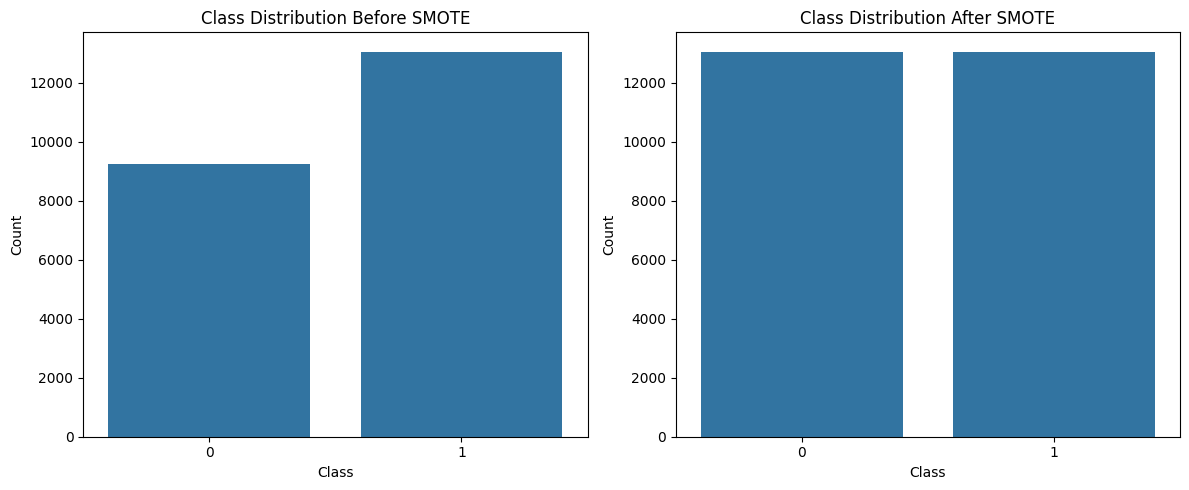

Before SMOTE: Depression
1    13049
0     9251
Name: count, dtype: int64
After SMOTE: Depression
1    13049
0    13049
Name: count, dtype: int64


In [7]:
# Apply SMOTE to the training data only
smote = SMOTE(random_state=16)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Visualize class distribution before and after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title("Class Distribution Before SMOTE")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

# After SMOTE
sns.countplot(x=y_train_resampled, ax=axes[1])
axes[1].set_title("Class Distribution After SMOTE")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# Print the new class distribution
print("Before SMOTE:", pd.Series(y_train).value_counts())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts())

## Machine Learning Models

In [9]:
def evaluate_model(model, name, X, y):
    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)
    print()

    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks([0.5, 1.5], ["No Depression", "Depression"])
    plt.yticks([0.5, 1.5], ["Depression", "Depression"])
    plt.show()

    return (accuracy, precision, recall, f1)

### Logistic Regression

In [ ]:
logistic_model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=16)
logistic_model.fit(X_train_resampled, y_train_resampled)
logistic_result = evaluate_model(logistic_model, "Logistic Regression", X_test, y_test)

### KNN

In [ ]:
parameter_values = {"n_neighbors": list(range(1, 20, 2)),
                    "weights": ["uniform", "distance"],
                    "p": [1, 1.5, 2], "n_jobs": [5]
                   }
gs_knn = KNeighborsClassifier()
gs = GridSearchCV(gs_knn, parameter_values, scoring="f1", n_jobs=-1)
gs.fit(X_train_resampled, y_train_resampled)

print("Best parameters: ", gs.best_params_)

knn_model = KNeighborsClassifier(**gs.best_params_)
knn_model.fit(X_train_resampled, y_train_resampled)
knn_result = evaluate_model(knn_model, "KNN", X_test, y_test)

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Train and evaluate a Decision Tree model
dt_model = DecisionTreeClassifier(    
    class_weight='balanced',
    criterion='entropy',
    max_depth=10,
    max_leaf_nodes=None,
    min_samples_leaf=2,
    min_samples_split=2,
    random_state=1217
    )
dt_model.fit(X_train_resampled, y_train_resampled)
print("Decision Tree Model Evaluation:")
evaluate_model(dt_model, "Decision Tree", X_test, y_test)

### Bagging

Bagging Model Evaluation:
Accuracy:  0.8297757847533632
Precision:  0.8334287349742415
Recall:  0.8880756328148826
F1 Score:  0.8598848368522073



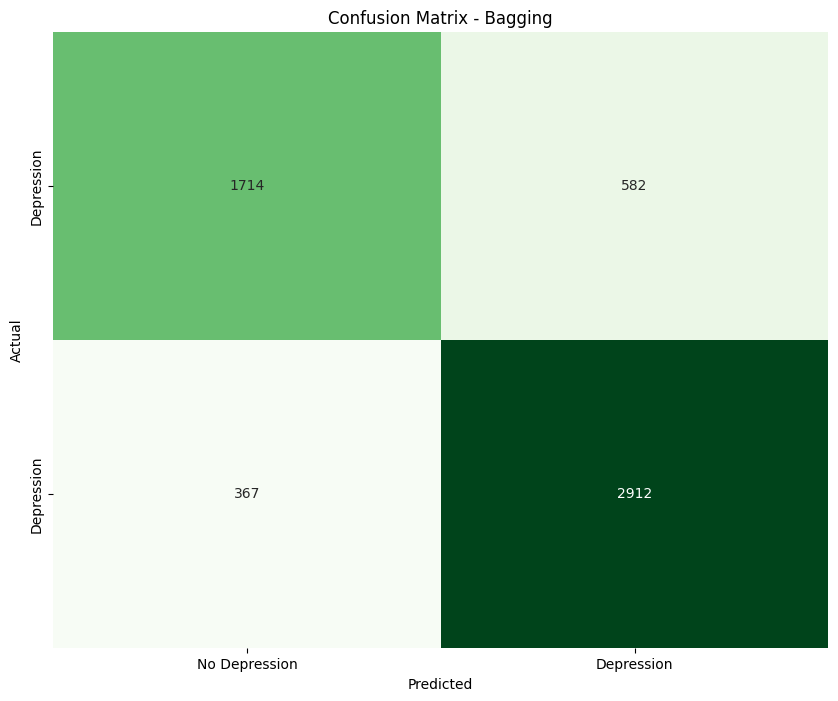

(0.8297757847533632,
 0.8334287349742415,
 0.8880756328148826,
 0.8598848368522073)

In [29]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

estimator = DecisionTreeClassifier()
bag_model = BaggingClassifier(
    estimator=estimator,
    n_estimators=100,
    max_samples=1.0,
    max_features=0.5,
    bootstrap=True,
    random_state=295
)

bag_model.fit(X_train_resampled, y_train_resampled)
print("Bagging Model Evaluation:")
evaluate_model(bag_model, "Bagging", X_test, y_test)


### AdaBoost

AdaBoost Model Evaluation:
Accuracy:  0.8396412556053812
Precision:  0.8665846910544113
Recall:  0.8597133272339128
F1 Score:  0.8631353337415799



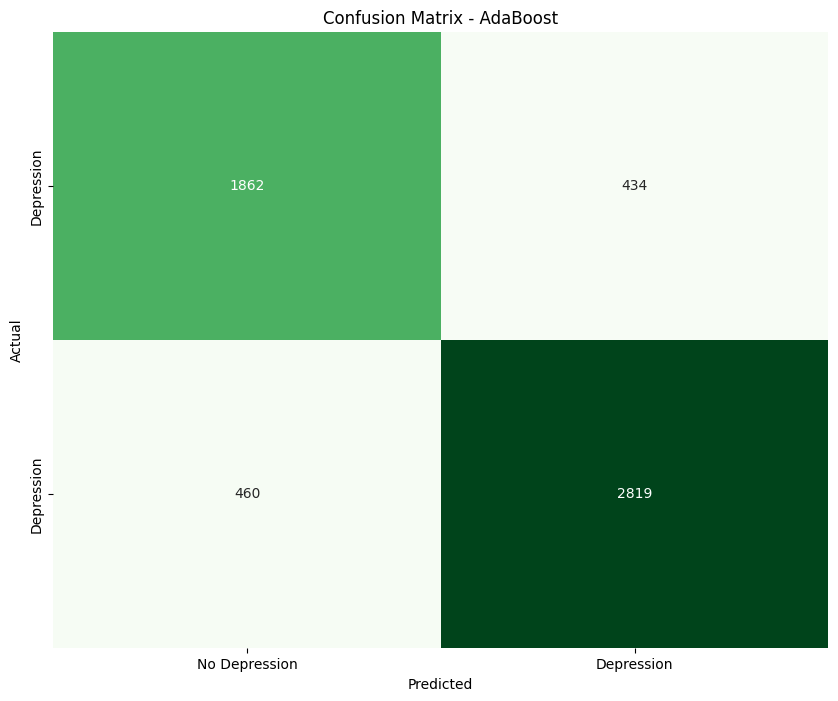

(0.8396412556053812,
 0.8665846910544113,
 0.8597133272339128,
 0.8631353337415799)

In [28]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

estimator = DecisionTreeClassifier(max_depth=1)
adc = AdaBoostClassifier(estimator=estimator, learning_rate=1.0, n_estimators=100, random_state=1366)


adc.fit(X_train_resampled, y_train_resampled)
print("AdaBoost Model Evaluation:")
evaluate_model(adc, "AdaBoost", X_test, y_test)

### Stacking

Accuracy:  0.8380269058295964
Precision:  0.8597819503331314
Recall:  0.86581274778896
F1 Score:  0.8627868105151193



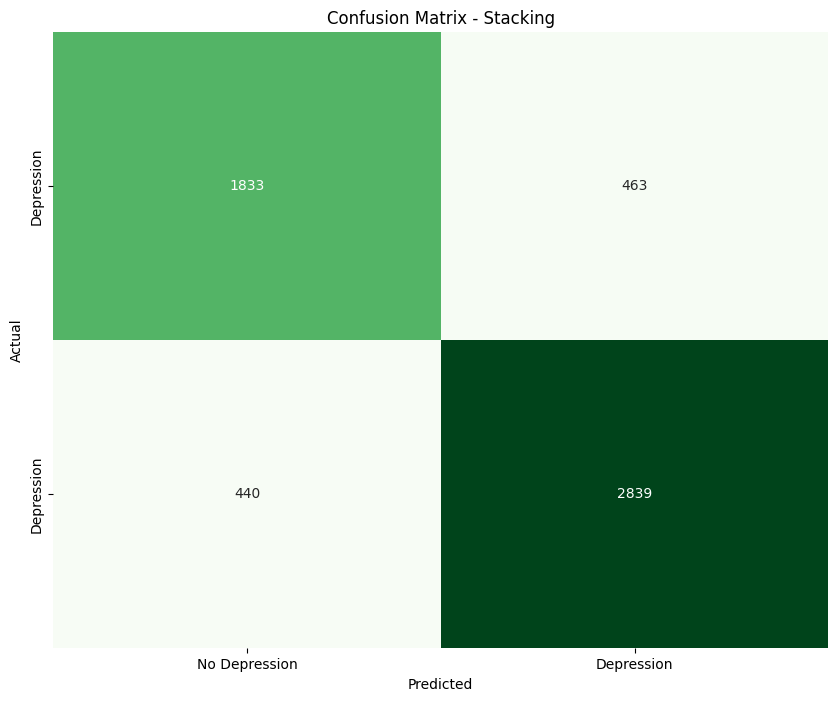

(0.8380269058295964, 0.8597819503331314, 0.86581274778896, 0.8627868105151193)

In [31]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier

# better base models than previous iteration
base_models = [
    ("Decision Tree", DecisionTreeClassifier(class_weight='balanced',
                                                criterion='entropy',
                                                max_depth=10,
                                                max_leaf_nodes=None,
                                                min_samples_leaf=2,
                                                min_samples_split=2,
                                                random_state=1217)),
    ("Random Forest", RandomForestClassifier(n_estimators=200,
                                                max_depth=None,
                                                max_features='sqrt',
                                                min_samples_leaf=1,
                                                min_samples_split=2,
                                                bootstrap=False,
                                                random_state=1217)),
    ("AdaBoost", AdaBoostClassifier(learning_rate=1.0, n_estimators=100, random_state=1366))
]

meta_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=100)

sc = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, passthrough=True)

sc.fit(X_train_resampled, y_train_resampled)

evaluate_model(sc, "Stacking", X_test, y_test)

### Random Forest

Random Forest Model Evaluation:
Accuracy:  0.8324663677130045
Precision:  0.8526315789473684
Recall:  0.8645928636779506
F1 Score:  0.8585705632949727



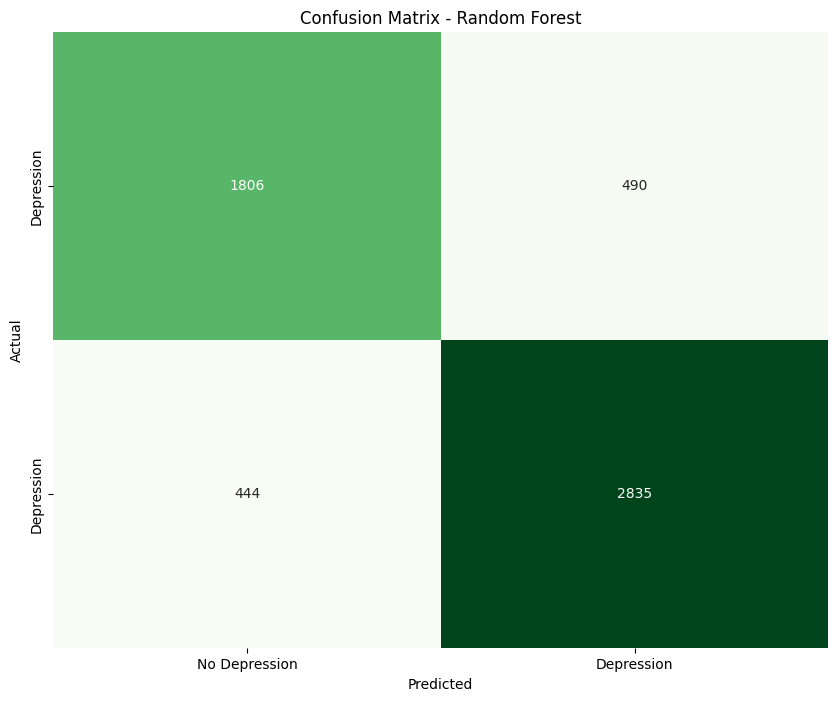

(0.8324663677130045,
 0.8526315789473684,
 0.8645928636779506,
 0.8585705632949727)

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Train and evaluate a Random Forest model
rf_model = RandomForestClassifier(n_estimators=200,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    bootstrap=False,
    random_state=1217
    )
rf_model.fit(X_train_resampled, y_train_resampled)
print("Random Forest Model Evaluation:")
evaluate_model(rf_model, "Random Forest", X_test, y_test)

### SVM

In [ ]:
from sklearn.svm import SVC

# Train and evaluate a Support Vector Machine (SVM) model
svm_model = SVC( 
    C=10,
    kernel='rbf',
    gamma='scale',
    degree=2,
    random_state=1217
    )
svm_model.fit(X_train_resampled, y_train_resampled)
print("SVM Model Evaluation:")
evaluate_model(svm_model, "SVM", X_test, y_test)

### Neural Networks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc

# Function to build a simple baseline model
def build_baseline_model(input_shape):
    model = Sequential(name='Baseline')
    model.add(Dense(32, activation='relu', input_shape=input_shape))  # Single hidden layer
    model.add(Dense(1, activation='sigmoid'))  # Output layer
    return model

# Function to build a deeper neural network model
def build_deep_model(input_shape):
    model = Sequential(name='Deep')
    model.add(Dense(64, activation='relu', input_shape=input_shape))  # First hidden layer
    model.add(Dropout(0.3))  # Dropout for regularization
    model.add(Dense(32, activation='relu'))  # Second hidden layer
    model.add(Dense(16, activation='relu'))  # Third hidden layer
    model.add(Dense(1, activation='sigmoid'))  # Output layer
    return model

# Function to build a wider neural network model
def build_wide_model(input_shape):
    model = Sequential(name='Wide')
    model.add(Dense(128, activation='relu', input_shape=input_shape))  # Wide hidden layer
    model.add(Dropout(0.4))  # Dropout for regularization
    model.add(Dense(1, activation='sigmoid'))  # Output layer
    return model

def build_model(name, input_shape):
    if name == 'Baseline':
        return build_baseline_model(input_shape)
    elif name == 'Deep':
        return build_deep_model(input_shape)
    elif name == 'Wide':
        return build_wide_model(input_shape)

# List of model types to train
models = ['Baseline', 'Deep', 'Wide']

# Loop through each model type, train, and evaluate
for name in models:
    print(f"\n Training {name} Model")

    # Build the model
    model = build_model(name, (X_train_resampled.shape[1],))

    # Compile the model with binary crossentropy loss and relevant metrics
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'precision', 'recall'])

    # Define early stopping callback to prevent overfitting
    early_stop = EarlyStopping(patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train_resampled, y_train_resampled,
                        validation_split=0.2,
                        epochs=100,
                        batch_size=32,
                        callbacks=[early_stop],
                        verbose=0)

    # Evaluate the model on test data
    print("Evaluating on Test Set:")
    results = model.evaluate(X_test, y_test, verbose=0)
    print(dict(zip(model.metrics_names, results)))  # Display metrics

    # Make predictions
    y_probs = model.predict(X_test)  # Probabilities
    y_pred = (y_probs > 0.5).astype(int)  # Convert probabilities to class labels

    # Display classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

    # Function to plot training history for each metric
    def plot_history(history, metric):
        plt.plot(history.history[metric], label=f'{metric} (train)')
        plt.plot(history.history[f'val_{metric}'], label=f'{metric} (test)')
        plt.title(f'{name} - {metric.capitalize()} over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.show()

    print("Metrics: \n")
    # Plot all relevant metrics
    for metric in ['accuracy', 'loss', 'precision', 'recall']:
        plot_history(history, metric)


### Feature engineering

In [ ]:
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
# RFE with XGboost

# Prepare data
X = df.drop(columns=['id', 'Depression'])
y = df['Depression']

# Scale features
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Wrapper method: Recursive Feature Elimination (RFE) with XGBoost
base_model = XGBClassifier(eval_metric='logloss', random_state=42)
rfe = RFE(estimator=base_model, n_features_to_select=10)
X_selected = rfe.fit_transform(X_scaled, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Fit model on selected features
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

# Evaluate
print("XGBoost with RFE-selected Features")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Depressed", "Depressed"],
            yticklabels=["Not Depressed", "Depressed"])
plt.title("Confusion Matrix - RFE + XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
#Chi squared feature selection with SVM


# Prepare data
X = df.drop(columns=['id', 'Depression'])
y = df['Depression']

# Chi2 requires non-negative data → use MinMaxScaler
X_scaled = MinMaxScaler().fit_transform(X)

# Select top 10 features using Chi-Squared test
selector = SelectKBest(score_func=chi2, k=10)
X_selected = selector.fit_transform(X_scaled, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Train SVM model
svm_model = SVC(kernel='linear')  # You can also try 'rbf'
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

# Evaluate
print("Chi-Squared Feature Selection + SVM")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Depressed", "Depressed"],
            yticklabels=["Not Depressed", "Depressed"])
plt.title("Confusion Matrix - Chi2 + SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
#L1 Lasso regularization with logistic regression

# Prepare data
X = df.drop(columns=['id', 'Depression'])
y = df['Depression']
X_scaled = StandardScaler().fit_transform(X)

# L1 Logistic Regression for feature selection
model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model.fit(X_scaled, y)

# Select features where coefficients are non-zero
import numpy as np
selected_mask = model.coef_[0] != 0
X_selected = X_scaled[:, selected_mask]

# Split data using only selected features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Retrain on selected features
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate
print("Embedded Method (L1 Logistic Regression)")
print("Selected features:", np.array(X.columns)[selected_mask])
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Depressed", "Depressed"],
            yticklabels=["Not Depressed", "Depressed"])
plt.title("Confusion Matrix - L1 Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data (assuming X is a pandas DataFrame)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

selected_features = []
remaining_features = list(range(X.shape[1]))
best_accuracy = 0
improved = True

while improved and remaining_features:
    improved = False
    best_candidate = None
    best_candidate_accuracy = best_accuracy

    for feature in remaining_features:
        trial_features = selected_features + [feature]
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train.iloc[:, trial_features], y_train)
        y_pred = model.predict(X_test.iloc[:, trial_features])
        acc = accuracy_score(y_test, y_pred)

        if acc > best_candidate_accuracy:
            best_candidate = feature
            best_candidate_accuracy = acc

    if best_candidate is not None:
        selected_features.append(best_candidate)
        remaining_features.remove(best_candidate)
        best_accuracy = best_candidate_accuracy
        improved = True
        print(f"Added feature {best_candidate} | Accuracy: {best_accuracy:.4f}")
    else:
        print("No further improvement. Stopping feature selection.")

# Final model
print("\nSelected features:", selected_features)
final_model = LogisticRegression(max_iter=1000)
final_model.fit(X_train.iloc[:, selected_features], y_train)
final_acc = accuracy_score(y_test, final_model.predict(X_test.iloc[:, selected_features]))
print(f"\nFinal model accuracy with selected features: {final_acc:.4f}")



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data (assuming X is a pandas DataFrame and y is your label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

selected_features = list(range(X.shape[1]))  # Start with all features
best_accuracy = 0
improved = True

# Train with all features to get initial accuracy
model = LogisticRegression(max_iter=1000)
model.fit(X_train.iloc[:, selected_features], y_train)
y_pred = model.predict(X_test.iloc[:, selected_features])
best_accuracy = accuracy_score(y_test, y_pred)

print(f"Initial accuracy with all features: {best_accuracy:.4f}")

# Begin backward elimination
while improved and len(selected_features) > 1:
    improved = False
    worst_feature = None
    best_candidate_accuracy = best_accuracy

    for feature in selected_features:
        trial_features = [f for f in selected_features if f != feature]
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train.iloc[:, trial_features], y_train)
        y_pred = model.predict(X_test.iloc[:, trial_features])
        acc = accuracy_score(y_test, y_pred)

        if acc >= best_candidate_accuracy:
            worst_feature = feature
            best_candidate_accuracy = acc

    if worst_feature is not None:
        selected_features.remove(worst_feature)
        best_accuracy = best_candidate_accuracy
        improved = True
        print(f"Removed feature {worst_feature} | Accuracy: {best_accuracy:.4f}")
    else:
        print("No improvement by removing any more features. Stopping.")

# Final model
print("\nSelected features after backward elimination:", selected_features)
final_model = LogisticRegression(max_iter=1000)
final_model.fit(X_train.iloc[:, selected_features], y_train)
final_acc = accuracy_score(y_test, final_model.predict(X_test.iloc[:, selected_features]))
print(f"\nFinal model accuracy: {final_acc:.4f}")


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize features (good practice for models like logistic regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the model
model = LogisticRegression(max_iter=1000)

# Perform 5-fold cross-validation using accuracy as the scoring metric
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')

# Output results
print("Cross-Validation Accuracy Scores:", cv_scores)
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")
